In this notebook we'll solve the Bernoulli Bandits problem using the QCLP formulation presented in the paper below:
https://www.ijcai.org/Proceedings/07/Papers/389.pdf

I'll also be borrowing from this video and the code presented in it:
https://www.youtube.com/watch?v=8GuQAfyvWYc&list=PLRwcSE2bmyBxc9u_tV65sZTGy729nqgiv&index=16&ab_channel=ICTPQuantitativeLifeSciences

In [1]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("c:\\Users\\Tassili\\Desktop\\FSC-optimization-main")
from QCLP_formulation import *
import networkx as nx
import os
os.environ['NEOS_EMAIL'] = 'malikbf5@gmail.com' 

# Two-armed Bernoulli Bandits...

  Credits: Andrea Mazzolini, Alberto Pezzotta 

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="200">
</div>

In the most general case, there is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="200">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll choose to focus on two symmetric states (A,B) of this square where we have the following probabilities:  
  Probability of winning in state A having chosen action (arm) 1: $P(r = 1 \,|\, s= A, a=1) = \theta$   
  Probability of winning in state A having chosen action (arm) 2: $P(r = 1 \,|\, s= A, a=2) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 1: $P(r = 1 \,|\, s= B, a=1) = 1 - \theta$   
  Probability of winning in state B having chosen action (arm) 2: $P(r = 1 \,|\, s= B, a=2) = \theta$   

Upon choosing $\theta$ we get the two states:

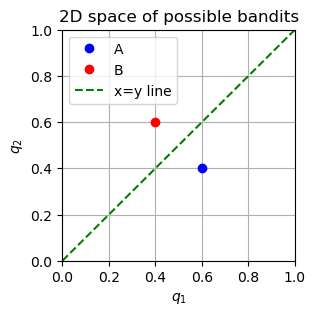

In [2]:
thetatest = 0.6
# Define the coordinates of the two points
point1 = (thetatest, 1- thetatest)
point2 = (1- thetatest, thetatest)

# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# set plot size
plt.gcf().set_size_inches(3, 3)
# Show plot
plt.show()


Following this we define our POMDP parameter values

In [3]:
#Define POMDP parameters

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

b0 = np.ones((num_states)) / num_states # uniform initial distribution over states
gamma = 0.5 # Discount factor 
theta = 0.8 # Bernoulli parameter for the reward

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = theta, 1 - theta
# state B
reward_model[1, 0], reward_model[1, 1] = 1 - theta, theta

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
for state, action, observation in product(s,a,o):
    if state == action:
        observation_model[state,action,observation] = bernoulliprob(theta, observation)
    else:
        observation_model[state,action,observation] = bernoulliprob(1-theta, observation)


Visualizing POMDP parameter values

In [4]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df = state_transition_model_df.rename_axis("(s',a,s)", axis="columns")
state_transition_model_df

"(s',a,s)","('A', 1, 'A')","('A', 1, 'B')","('A', 2, 'A')","('A', 2, 'B')","('B', 1, 'A')","('B', 1, 'B')","('B', 2, 'A')","('B', 2, 'B')"
Transition probability,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [5]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.8,0.2
B,0.2,0.8


In [6]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability'])
observation_model_df.rename_axis("(s',a,o)", axis="index")

,"('A', 1, 0)","('A', 1, 1)","('A', 2, 0)","('A', 2, 1)","('B', 1, 0)","('B', 1, 1)","('B', 2, 0)","('B', 2, 1)"
"(s',a,o)",,,,,,,,
Observation probability,0.2,0.8,0.8,0.2,0.8,0.2,0.2,0.8


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="600">
</div>

Where:  
The variable $x(q', a, q, o)$ represents $P(q', a|q, o)$  
The variable $y(q, s)$ represents $V(q, s)$  
$q_0$ is the initial controller node  
$o_k$ is an arbitrary fixed observation  

Note that $P(q', a|q, o)= P(q'|q, a, o) P(a|q)$ 

And $\sum{q'} P(q', a|q, o) = P(a|q)$

In [8]:
# num_nodes = 4
# q = list(range(num_nodes)) # Nodes in the FSC
# newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)





# opt = SolverFactory('ipopt')
# opt.options["print_user_options"] = "yes"
# opt.options["print_options_documentation"] = "yes"
# es = opt.solve(newmodel) 
# print(res.write())
# opt.solve(newmodel, tee=True).write()
# newmodel.display()
# newmodel.y.pprint()
# newmodel.x.pprint()
# newmodel.pprint()





# solver_manager = SolverManagerFactory('neos')
# results = solver_manager.solve(newmodel, solver="snopt")
# results.write()
# newmodel.x.pprint()
# newmodel.y.pprint()
# newmodel.pprint()
# adf, ndf = actionselect_nodetrans(newmodel.x)
# vdf = value_dataframe(newmodel.y)
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print("Action selection")
#     print(adf)
#     print("\n")
#     print("Node Transition")
#     print(ndf)
#     print("\n")
#     print("Value")
#     print(vdf)

In [7]:
def display_df(name= "", vdf = None, adf = None, ndf = None):
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):
        if vdf is not None:
            print("Value " + name)
            print(vdf)
            print("\n")
        if adf is not None:
            print("Action selection "+ name)
            print(adf)
            print("\n")
        if ndf is not None:
            print("Node Transition "+ name)
            print(ndf[ndf["P(q\',a | q,o)"] != 0].T)


# Creating Solution dataframes

In [9]:
# # create value dataframe
# def value_dataframe(newmodel,horiz=True, name ="V(q,s)"):
#     optimal_y = {"(q,s)": [key for key in newmodel.y.get_values().keys()],
#                   name: [newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys()]}
#     if horiz:
#         optimal_y_df = pd.DataFrame(optimal_y).T   
#         # specify column names
#         optimal_y_df.columns = optimal_y_df.iloc[0]
#         # drop extra row
#         optimal_y_df = optimal_y_df.drop(optimal_y_df.index[0])
#         # add objective function value
#         optimal_y_df.insert(0,"objective funct",value(newmodel.obj))
#         # add mean value
#         optimal_y_df.insert(1,"mean value",float(optimal_y_df.mean(axis=1)[0]))
#         # add value over nodes
#         optimal_y_df.insert(2,
#                             "value for nodes V(q)",
#                             str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[0] == qnode)
#                                    /len(newmodel.s),2) 
#                                    for qnode in newmodel.q]))
#         # add value over states
#         optimal_y_df.insert(3,"value for states V(s)",
#                             str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[1] == state)
#                                    /len(newmodel.q),2) 
#                              for state in newmodel.s]))
#     else:
#         optimal_y_df = pd.DataFrame(optimal_y)
#         # set index
#         optimal_y_df = optimal_y_df.set_index("(q,s)")
#         # add objective function value
#         optimal_y_df.loc["objective funct"] = value(newmodel.obj)
#         # add mean value
#         optimal_y_df.loc["mean value"] = float(optimal_y_df.mean(axis=1)[0])
#         # add value over nodes
#         optimal_y_df.loc["value for nodes V(q)"] = str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() 
#                                                               if key[0]==qnode)/len(newmodel.s),3) 
#                                                               for qnode in newmodel.q])
#         # add value over states
#         optimal_y_df.loc["value for states V(s)"] = str([round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() 
#                                                                if key[1]==si)/len(newmodel.q),3) 
#                                                                for si in newmodel.s])
        
#     return optimal_y_df

# # create action selection and node transition dataframes
# def actionselect_nodetrans(newmodelx, horiz_action = True, horiz_trans = False):
#     nodetrans = {}
#     actionselect = {}

#     for key in newmodelx.get_values().keys():
#         index = key[1:]
#         actionselect[key[1:3]] = sum(newmodelx.get_values()[key] for key in newmodelx.get_values().keys() if key[1:] == index)
#         nodetrans[key] = 0 
#         if actionselect[key[1:3]] != 0:
#             nodetrans[key] = newmodelx.get_values()[key] / actionselect[key[1:3]]

#     actionselectdict = [{"(a,q)": key, "P(a | q)": actionselect[key]}for key in actionselect.keys()]
#     if horiz_action:
#         actionselectdf = pd.DataFrame(actionselectdict).T
#         actionselectdf.columns = actionselectdf.iloc[0]
#         actionselectdf.drop(actionselectdf.index[0], inplace=True)
#     else:
#         actionselectdf = pd.DataFrame(actionselectdict)
#         actionselectdf = actionselectdf.set_index("(a,q)")
    
#     nodetransdict = [{"(q',a,q,o)": key, "P(q' | q, a, o)": round(nodetrans[key],3), "P(q',a | q,o)": round(value(newmodelx[key]),3)}for key in nodetrans.keys()]
#     nodetransdf = pd.DataFrame(nodetransdict)
#     nodetransdf.set_index("(q',a,q,o)", inplace=True)
#     if horiz_trans:
#         nodetransdf = pd.DataFrame(nodetransdict).T
#         nodetransdf.columns = nodetransdf.iloc[0]
#         nodetransdf.drop(nodetransdf.index[0], inplace=True)
#     else:
#         nodetransdf = pd.DataFrame(nodetransdict)
#         nodetransdf.set_index("(q',a,q,o)", inplace=True)
    
#     return actionselectdf, nodetransdf

# # optimal_ydf = value_dataframe(newmodel.y,horiz=True)
# # optimal_ydf
# # adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
# # adf

In [10]:
# # Win Stay Lose Shift strategy for two node controller
# value_WSLS2 = [{"(q,s)":(qi,si), "V_WSLS_2(q,s)": 1.47 if qi == si else 0.87}
#             for (qi,si) in product(range(2),range(2))]
# value_WSLS2df = pd.DataFrame(value_WSLS2).T
# value_WSLS2df.columns = value_WSLS2df.iloc[0]
# value_WSLS2df.drop(value_WSLS2df.index[0], inplace=True)
# value_WSLS2df.insert(0,"mean value",float(value_WSLS2df.mean(axis=1)[0]))
# value_WSLS2df.insert(0,"objective funct",0.5* (1.47 + 0.87))
# value_WSLS2df.insert(2,"value for nodes V(q)", str([(1.47+0.87)/2 for i in range(2)]))
# value_WSLS2df.insert(3,"value for states V(s)", str([(1.47+0.87)/2 for i in range(2)]))
# value_WSLS2df

In [8]:
def calculate_value_list(model):
    # matrix of coefficients
    a = np.zeros((len(model.q)*len(model.s),len(model.q)*len(model.s)))
    # vector of constants
    b = np.zeros(len(model.q)*len(model.s))
    # loop the same way in qclp_formulation
    i = 0
    for q_ in model.q:
        for s_ in model.s:
            # sum_a( sum_q'(x[q',a,q,o_k]) * R[s, a] )
            b[i] = -sum(
                sum([value(model.x[qp_, a_, q_, 0]) for qp_ in model.q])
                * reward_model[s_, a_]   for a_ in model.a)
            j = 0
            for qp_ in model.q:
                for sp_ in model.s:
                    # sum_a( sum_o( gammma * P(s'|s,a) * O(o|s',a) * x[q',a,q,o] ) )
                    a[i,j] = sum(
                            gamma * state_transition_model[sp_,a_,s_] *
                            observation_model[sp_, a_, o_] *
                            value(model.x[qp_, a_, q_, o_]) 
                        for a_ in model.a for o_ in model.o) - int(qp_ == q_ and sp_ == s_)
                    j += 1
            i += 1
    # solve the linear system and get values for this strategy
    v = list(np.linalg.solve(a, b))
    return v            

In [17]:
# objective function for WSLS heuristic strategies
# max sum_s b_0 y(q_0,s)
obj = "first node"
# max sum_s_q b_0 y(q,s) / |q|
# obj = "all nodes"

Win Stay Lose Shift heuristics

Controller size = 2

In [13]:
# initialize the model variable x with win_stay lose_shift strategy for 2 nodes controller for BB
def win_stay_lose_shift_2_init(newmodel,solvername = "snopt"):
    # initial values for the variables with Win-Stay Lose-Shift policy
    for qnode in newmodel.q:
        for actionn in newmodel.a:
            for qnodeprime in newmodel.q:
                for obs in newmodel.o:
                    if qnode == qnodeprime and qnode == actionn and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                        # print(f"being in {qnode} having chosen {actionn} and observed {obs} we stay in {qnodeprime}", newmodel.x[qnodeprime,actionn,qnode,obs].value)
                    elif qnode != qnodeprime and qnode == actionn and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1 
                        # print(f"being in {qnode} having chosen {actionn} and observed {obs} we shift to {qnodeprime}",newmodel.x[qnodeprime,actionn,qnode,obs].value)
                    else:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0
                        # print(f"being in {qnode} having chosen {actionn} and observed {obs} we don't go to {qnodeprime}",newmodel.x[qnodeprime,actionn,qnode,obs].value)
    # get value of this strategy
    value_of_strat = calculate_value_list(newmodel)
    # Win Stay Lose Shift strategy for two node controller dataframe for BB
    value_WSLS2 = {"(q,s)":[(qi,si) for (qi,si) in product(range(2),range(2))]}
    value_WSLS2["V_WSLS_2(q,s)"] = value_of_strat
    value_WSLS2df = pd.DataFrame(value_WSLS2).T
    value_WSLS2df.columns = value_WSLS2df.iloc[0]
    value_WSLS2df.drop(value_WSLS2df.index[0], inplace=True)
    value_WSLS2df.insert(len(value_WSLS2df.columns),"mean value",float(value_WSLS2df.mean(axis=1)[0]))
    value_WSLS2df.insert(len(value_WSLS2df.columns),"objective funct",(value_WSLS2df[(0,0)]+value_WSLS2df[(0,1)])*0.5)    
    # solve the model
    opt = SolverManagerFactory("neos")
    opt.solve(newmodel, solver = solvername)
    # results dataframe
    vdf = value_dataframe(newmodel,name ="V_WSWS_2_init(q,s)")
    adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
    return newmodel, vdf, adf, ndf, value_WSLS2df

In [14]:
num_nodes = 2
newmodel2 = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)
newmodel2, vwsls2, adf2, ndf2, value_WSLS2df = win_stay_lose_shift_2_init(newmodel2)
# display_df(vdf = vwsls2, adf = adf2, ndf = ndf2, name = "wsls2")

In [15]:
vwsls2

"(q,s)",objective funct,mean value,value for nodes V(q),value for states V(s),"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
"V_WSWS_2_init(q,s)",1.18,1.18,"[1.18, 1.18]","[1.18, 1.18]",1.48,0.88,0.879999,1.48


In [16]:
value_WSLS2df

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)",mean value,objective funct
"V_WSLS_2(q,s)",1.48,0.88,0.88,1.48,1.18,1.18


Controller size = 3

In [17]:
# initialize the model variable x with win_stay lose_shift strategy for 3 nodes controller for BB
def win_stay_lose_shift_3_init(newmodel,solvername = "snopt"):
    # initial values for the variables with Win-Stay Lose-Shift policy
    for qnode in newmodel.q:
        for actionn in newmodel.a:
            for qnodeprime in newmodel.q:
                for obs in newmodel.o:
                    # if we win in the node corresponding to action, we stay
                    if qnodeprime == qnode and qnode == actionn and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # if we lose in the node corresponding to action, we shift to the intermediate node
                    elif qnodeprime == 2 and qnode == actionn and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # if we win in the intermediate node, we shift to node corresponding to action taken
                    elif qnodeprime == actionn and qnode == 2 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5 * 1 # P(a | 2) = 0.5
                    # if we lose in the intermediate node, we shift to node corresponding to the other action
                    elif qnodeprime!= actionn and qnode == 2 and qnodeprime != 2 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5 * 1 # P(a | 2) = 0.5
                    # the rest is 0
                    else: 
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0
    # get value of this strategy
    value_of_strat = calculate_value_list(newmodel)
    # Win Stay Lose Shift strategy for three node controller dataframe for BB
    value_WSLS3 = {"(q,s)":[(qi,si) for (qi,si) in product(range(3),range(2))]}
    value_WSLS3["V_WSLS_3(q,s)"] = value_of_strat
    value_WSLS3df = pd.DataFrame(value_WSLS3).T
    value_WSLS3df.columns = value_WSLS3df.iloc[0]
    value_WSLS3df.drop(value_WSLS3df.index[0], inplace=True)
    value_WSLS3df.insert(len(value_WSLS3df.columns),"mean value",float(value_WSLS3df.mean(axis=1)[0]))
    value_WSLS3df.insert(len(value_WSLS3df.columns),"objective funct",(value_WSLS3df[(0,0)]+value_WSLS3df[(0,1)])*0.5)
    # solve the model
    opt = SolverManagerFactory("neos")
    opt.solve(newmodel, solver = solvername)
    # results dataframe
    vdf = value_dataframe(newmodel,name ="V_WSWS_3_init(q,s)")
    adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
    return newmodel, vdf, adf, ndf, value_WSLS3df

In [18]:
num_nodes = 3
newmodel3 = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model,obj = obj)
newmodel3, vwsls3, adf3, ndf3, value_WSLS3df = win_stay_lose_shift_3_init(newmodel3)
# vwsls3
# display_df(vdf = vwsls3, adf = adf3, ndf = ndf3, name = "wsls3")

In [19]:
vwsls3

"(q,s)",objective funct,mean value,value for nodes V(q),value for states V(s),"(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)"
"V_WSWS_3_init(q,s)",1.1875,1.160714,"[1.188, 1.094, 1.187]","[0.975, 1.338]",1.475,0.9,0.6,1.5875,0.85,1.525


In [20]:
value_WSLS3df

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)",mean value,objective funct
"V_WSLS_3(q,s)",1.53125,0.75,0.75,1.53125,1.1875,1.1875,1.15625,1.140625


In [21]:
adf3

"(a,q)","(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)"
P(a | q),1.0,0.0,0.0,-0.0,1.0,1.0


Controller size = 4

In [22]:
# initialize the model variable x with win_stay lose_shift strategy for 4 nodes controller for BB
def win_stay_lose_shift_4_init(newmodel,solvername = "snopt"):
    # initial values for the variables with Win-Stay Lose-Shift policy
    for qnode in newmodel.q:
        for actionn in newmodel.a:
            for qnodeprime in newmodel.q:
                for obs in newmodel.o:
                    # from node 0 having picked first action and won, we stay
                    if qnode ==  0 and qnodeprime == 0 and actionn == 0 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 0 having picked first action and lost, we shift to node 1
                    elif qnode == 0 and qnodeprime == 1 and actionn == 0 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 1 having picked first action and won, stochastic transition
                    elif qnode == 1 and qnodeprime == 0 and actionn == 0 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    elif qnode == 1 and qnodeprime == 2 and actionn == 0 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    # from node 1 having picked first action and lost again, we shift to node 2
                    elif qnode == 1 and qnodeprime == 2 and actionn == 0 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 2 having picked the second action and won, we stay
                    elif qnode == 2 and qnodeprime == 2 and actionn == 1 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                     # from node 2 having picked the second action and lost, we shift to node 3
                    elif qnode == 2 and qnodeprime == 3 and actionn == 1 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # from node 3 having picked the second action and won, stochastic transition
                    elif qnode == 3 and qnodeprime == 2 and actionn == 1 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    elif qnode == 3 and qnodeprime == 0 and actionn == 1 and obs == 1:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0.5
                    # from node 3 having picked the second action and lost again, we shift to node 0
                    elif qnode == 3 and qnodeprime == 0 and actionn == 1 and obs == 0:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 1
                    # else = 0
                    else:
                        newmodel.x[qnodeprime,actionn,qnode,obs] = 0
    # get value of this strategy
    value_of_strat = calculate_value_list(newmodel)
    # Win Stay Lose Shift strategy for four node controller dataframe for BB
    value_WSLS4 = {"(q,s)":[(qi,si) for (qi,si) in product(range(4),range(2))]}
    value_WSLS4["V_WSLS_4(q,s)"] =  value_of_strat
    value_WSLS4df = pd.DataFrame(value_WSLS4).T
    value_WSLS4df.columns = value_WSLS4df.iloc[0]
    value_WSLS4df.drop(value_WSLS4df.index[0], inplace=True)
    value_WSLS4df.insert(len(value_WSLS4df.columns),"mean value",float(value_WSLS4df.mean(axis=1)[0]))
    value_WSLS4df.insert(len(value_WSLS4df.columns),"objective funct",(value_WSLS4df[(0,0)]+value_WSLS4df[(0,1)])*0.5)
    # solve the model
    opt = SolverManagerFactory("neos")
    opt.solve(newmodel, solver = solvername)
    # results dataframe
    vdf = value_dataframe(newmodel,name ="V_WSWS_4_init(q,s)")
    adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action=True,horiz_trans=False)
    return newmodel, vdf, adf, ndf, value_WSLS4df   

In [23]:
num_nodes = 4
newmodel4 = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model, obj = obj)
newmodel4, vwsls4, adf4, ndf4, value_WSLS4df = win_stay_lose_shift_4_init(newmodel4)
# vwsls4
# display_df(vdf = vwsls4, adf = adf4, ndf = ndf4, name = "wsls4")

In [24]:
vwsls4

"(q,s)",objective funct,mean value,value for nodes V(q),value for states V(s),"(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)","(3, 0)","(3, 1)"
"V_WSWS_4_init(q,s)",1.1875,1.165459,"[1.187, 1.182, 1.094, 1.187]","[1.046, 1.28]",1.475,0.9,1.257823,1.106309,0.6,1.5875,0.85,1.525


In [25]:
value_WSLS4df

"(q,s)","(0, 0)","(0, 1)","(1, 0)","(1, 1)","(2, 0)","(2, 1)","(3, 0)","(3, 1)",mean value,objective funct
"V_WSLS_4(q,s)",1.550099,0.635248,1.300594,0.929307,0.635248,1.550099,0.929307,1.300594,1.103812,1.092673


# Graph visualizations

In [26]:
# function that returns positions of action nodes circling a controller node
def action_node_pos(number_actions,origin, radius = 1, angle = 0):
    angle_increment = np.divide(np.multiply(2 , np.pi) , number_actions)
    action_pos = []
    for i in range(number_actions):
        action_pos.append((np.multiply(np.cos(angle),radius)+origin[0], np.multiply(np.sin(angle),radius) + origin[1]))
        angle += angle_increment
    return action_pos

# l = action_node_pos(3, (0,0), angle = np.pi/2)
# print(l)
# for i in l:
#     plt.plot(i[0], i[1], 'bo')

# function that returns positions of nodes in a horizontal line
def horiz_pos(number_nodes, space = 1, origin = (0,0)):
    qnode_pos_list = []
    if number_nodes % 2 == 0:
        qnode_pos_list.append((origin[0] + space * 0.5, origin[1]))
        qnode_pos_list.append((origin[0] - space * 0.5, origin[1]))
        for i in range(1,number_nodes //2):
            qnode_pos_list.append((qnode_pos_list[0][0] + (i)* space, qnode_pos_list[0][1] ))
            qnode_pos_list.append((qnode_pos_list[1][0] - (i)*space, qnode_pos_list[1][1] ))
    else:
        qnode_pos_list.append(origin)
        for i in range(number_nodes // 2):
            qnode_pos_list.append((origin[0] + (i+1) * space, origin[1] ))
            qnode_pos_list.append((origin[0] - (i+1) * space, origin[1] ))
    return qnode_pos_list

# l = horiz_pos(6, space = 0.5, origin = (0,0))
# print(l)
# for i in l:
#     plt.plot(i[0], i[1], 'bo', label='A')

In [27]:
# function that returns action selection and node transition dict

# function that draws action selection graph

# function that draws node transition graph

In [28]:
# nodes = [ "q" + str(i) for i in q]
# states = ["s" + str(i) for i in s]
# actions = ["a" + str(i) for i in a]
# observations = ["o" + str(i) for i in o]

# # Create action selection graph
# G = nx.MultiDiGraph() # multi directed graph
# print()
# # action node list
# actionnodelist = []

# # dictionary for labels
# labels_dict = {}

# for qnode in nodes:
#     G.add_node(qnode)
#     labels_dict[qnode] = qnode
#     for actionnode in actions:
#         G.add_node((actionnode, qnode))
#         actionnodelist.append((actionnode, qnode))
#         labels_dict[(actionnode, qnode)] = actionnode
#         G.add_edge(qnode, (actionnode, qnode), 
#         probability = actionselect[(int(actionnode[1]), int(qnode[1]))]
#         )

# # radius surrounding origin for controller nodes
# radius1 = 1
# # radius surrounding controller node for action nodes
# radius2 = 0.5

# qnodepos = action_node_pos(len(nodes),origin = (0,0), radius = radius1)

# pos = {}

# for qnode in nodes:
#     pos[qnode] = qnodepos.pop(0)
#     i = 0
#     # position action nodes surrounding the controller node
#     actionnodepos = action_node_pos(len(actions), pos[qnode], radius = radius2)
#     for actionnode in actions:
#         pos[(actionnode, qnode)] = actionnodepos[i]
#         i += 1

# # Draw nodes
# # controller nodes
# nx.draw_networkx_nodes(G, pos,nodes, node_size=1000, node_color='skyblue')
# # action nodes
# nx.draw_networkx_nodes(G, pos,actionnodelist, node_size=500, node_color='red')

 
# # Draw edges
# widthlist = [G[e[0]][e[1]][0]['probability'] for e in G.edges]
# nx.draw_networkx_edges(G, pos, width=widthlist, arrows=True,  connectionstyle='arc3, rad = 0.3', arrowsize = 15)

# # Draw labels
# nx.draw_networkx_labels(G, pos,labels = labels_dict, font_size=10, font_family="sans-serif")


# plt.title('Action Selection')
# plt.show()

In [29]:
# nodesprime = [qnode + "\'" for qnode in nodes]
# # create transition graph
# G1 = nx.MultiDiGraph() 

# # create controller nodes (q')
# for qprime in nodesprime:
#     G1.add_node(qprime)
    
# # transition node list
# transnodelist = []

# # create (a,q,o) nodes and add edges to q' nodes
# for qnode in nodes:
#     for actionnode in actions:
#         for observation in observations:
#             G1.add_node((actionnode, qnode, observation))
#             transnodelist.append((actionnode, qnode, observation))
#             for qprime in nodesprime:
#                 G1.add_edge((actionnode, qnode, observation), qprime , probability = nodetrans[(int(qprime[1]), int(actionnode[1]), int(qnode[1]), int(observation[1]))])

# # positions for controller nodes (q')
# space_nodes = 1
# # position nodes horizontally with space_nodes between them
# nodepos = horiz_pos(len(nodes), space = space_nodes)
# for qprime in nodesprime:
#     pos[qprime] = nodepos.pop(0)

# # positions for (a,q,o) nodes
# radius = len(nodesprime) * space_nodes / 1.5
# # position (a,q,o) nodes circularly around the controller nodes (q')
# nodetranspos = action_node_pos(len(actions)* len(nodes) * len(observations), (0,0), radius)
# for qnode in nodes:
#     for actionnode in actions:
#         for observation in observations:
#             pos[(actionnode, qnode, observation)] = nodetranspos.pop(0)

# # Draw nodes
# nx.draw_networkx_nodes(G1, pos,nodesprime, node_size=600, node_color='skyblue')
# nx.draw_networkx_nodes(G1, pos,transnodelist, node_size=2000, node_color='red')

# # Draw labels
# aq_labels = {currnode: currnode for currnode in G1.nodes if type(currnode) == str}
# aq_labels = {currnode: (str(currnode[0]) + ',' + str(currnode[1]) + ',' + str(currnode[2])  if type(currnode) == tuple else currnode ) for currnode in G1.nodes} 
# nx.draw_networkx_labels(G1, pos,aq_labels, font_size=9, font_family="sans-serif")

# # Draw edges

# width_prob = [G1[e[0]][e[1]][0]['probability'] for e in G1.edges()]
# nx.draw_networkx_edges(G1, pos, width= width_prob , arrows=True, connectionstyle='arc3, rad = 0.3', arrowsize = 20)

# # plt.axis('off')
# plt.title('Controller Node Transtiion')
# plt.show()


# Generating instances

In [9]:
def opt_instances(num_nodes_list, num_instances_for_each_numnodes,num_states, num_actions, num_observations, b0, gamma, state_transition_model, reward_model, observation_model, obj = "first node"):
    sol = {}
    for num_node in num_nodes_list:
        sol[num_node] = {}
        for instance in range(num_instances_for_each_numnodes):
            sol[num_node][instance] = {}
            # call qclp funct
            newmodel = qclp_formulation(num_states, num_actions, num_observations, num_node, b0, gamma, state_transition_model, reward_model, observation_model, obj = obj)
            # generate x values randomly
            generate_randomx(newmodel, num_node, num_actions)
            # newmodel.x.pprint()
            # print([sum(newmodel.x[qnodeprime,actionn,qnode,obs].value for qnodeprime in newmodel.q for actionn in newmodel.a) for qnode in newmodel.q for obs in newmodel.o])
            # print([sum(newmodel.x[qnodeprime,actionn,qnode,obs].value for qnodeprime in newmodel.q) == sum(newmodel.x[qnodeprime,actionn,qnode,0].value for qnodeprime in newmodel.q)  for qnode in newmodel.q for actionn in newmodel.a for obs in newmodel.o])
            # call opt
            opt = SolverManagerFactory('neos')
            opt.solve(newmodel, solver = "snopt")
            # save results
            # dataframe for y
            vdf = value_dataframe(newmodel)
            # dataframe for action selection and node transition
            adf, ndf = actionselect_nodetrans(newmodel.x, horiz_action = True, horiz_trans = True)
            sol[num_node][instance] = {"model": newmodel, "value df": vdf, 
                                       "action selection df": adf, "node transition df": ndf,
                                       "objective": value(newmodel.obj),
                                       "mean value": sum(newmodel.y.get_values().values()) / len(newmodel.y.get_values()),
                                       "mean value for nodes": [round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[0] == qnode)/len(newmodel.s),2) for qnode in newmodel.q],
                                       "mean value for states": [round(sum(newmodel.y.get_values()[key] for key in newmodel.y.get_values().keys() if key[1] == state)/len(newmodel.q),2) for state in newmodel.s]}
        # mean value for a given controller size over instances
        sol[num_node]["mean value"] = round(sum(sol[num_node][instance]["mean value"] 
                                                for instance in range(num_instances_for_each_numnodes)) 
                                                / num_instances_for_each_numnodes,3)
        # max objective function for a given controller size over instances
        sol[num_node]["max obj"] = max([sol[num_node][instance]["objective"] 
                                                 for instance in range(num_instances_for_each_numnodes)])
        # mean objective function for a given controller size over instances
        sol[num_node]["mean obj"] = sum(sol[num_node][instance]["objective"] 
                                                 for instance in range(num_instances_for_each_numnodes)) / num_instances_for_each_numnodes
        # mean value for nodes for a given controller size over instances
        sol[num_node]["mean value for nodes"] = np.round(sum(np.array(
            sol[num_node][instance]["mean value for nodes"]) 
            for instance in range(num_instances_for_each_numnodes)) 
            / num_instances_for_each_numnodes,3)
        # mean value for states a given controller size over instances
        sol[num_node]["mean value for states"] = np.round(sum(np.array(
            sol[num_node][instance]["mean value for states"]) 
            for instance in range(num_instances_for_each_numnodes)) 
            / num_instances_for_each_numnodes,3)
        # value df for a given controller size    
        sol[num_node]["value df"] = pd.concat([sol[num_node][instance]["value df"] for instance in range(num_instances_for_each_numnodes)])
        # action selection df for a given controller size
        sol[num_node]["action select df"] = pd.concat([sol[num_node][instance]["action selection df"] for instance in range(num_instances_for_each_numnodes)])
        # node transition df for a given controller size
        sol[num_node]["node trans df"] = pd.concat([sol[num_node][instance]["node transition df"] for instance in range(num_instances_for_each_numnodes)])
    
    # solution dataframe
    sol["dataframe"] = pd.DataFrame({ "controller size": num_nodes_list, 
                                     "max obj": [sol[num_node]["max obj"] for num_node in num_nodes_list],
                                     "mean obj": [sol[num_node]["mean obj"] for num_node in num_nodes_list],
                                     "mean value": [sol[num_node]["mean value"] for num_node in num_nodes_list], 
                                     "mean value for nodes V(q)": [sol[num_node]["mean value for nodes"] for num_node in num_nodes_list], 
                                     "mean value for states V(s)": [sol[num_node]["mean value for states"] for num_node in num_nodes_list]})
    sol["dataframe"].set_index("controller size", inplace=True)
    return sol

In [31]:
number_instances = 10
controller_size_list = [2,3,4]
sol = opt_instances(controller_size_list, number_instances,num_states, num_actions, num_observations, b0, gamma, state_transition_model, reward_model, observation_model, obj = obj)
sol["dataframe"]

,max obj,mean obj,mean value,mean value for nodes V(q),mean value for states V(s)
controller size,,,,,
2,1.180000,1.18000,1.180,"[1.18, 1.18]","[1.18, 1.18]"
3,1.190026,1.18476,1.154,"[1.185, 1.129, 1.15]","[1.079, 1.232]"
4,1.195762,1.18906,1.138,"[1.191, 1.134, 1.09, 1.14]","[1.106, 1.169]"


In [38]:
# Value of controllers given a controller size
# controllersize = 4
# sol[controllersize]["value df"]

In [33]:
# Action selection given a controller size
# sol[controllersize]["action select df"]


In [34]:
# Node transitions given a controller size
# with pd.option_context('display.max_rows', None,'display.max_columns', None,'display.precision', 3):
# sol[controllersize]["node trans df"]

### Comparison of results

In [35]:
comparisondf = pd.DataFrame({"controller size":[2,3,4],
                             "random RESTART": list(sol["dataframe"]["max obj"]),
                             "WSLS RESTART": [vwsls2["objective funct"][0],vwsls3["objective funct"][0], vwsls4["objective funct"][0]],
                             "WSLS": [value_WSLS2df["objective funct"][0],value_WSLS3df["objective funct"][0],value_WSLS4df["objective funct"][0]]})
comparisondf.set_index("controller size", inplace=True)
comparisondf

,random RESTART,WSLS RESTART,WSLS
controller size,,,
2,1.180000,1.1800,1.180000
3,1.190026,1.1875,1.140625
4,1.195762,1.1875,1.092673


when first node
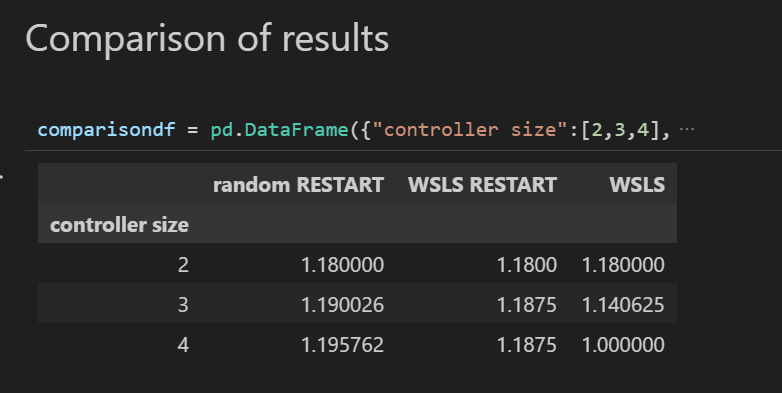

when all nodes
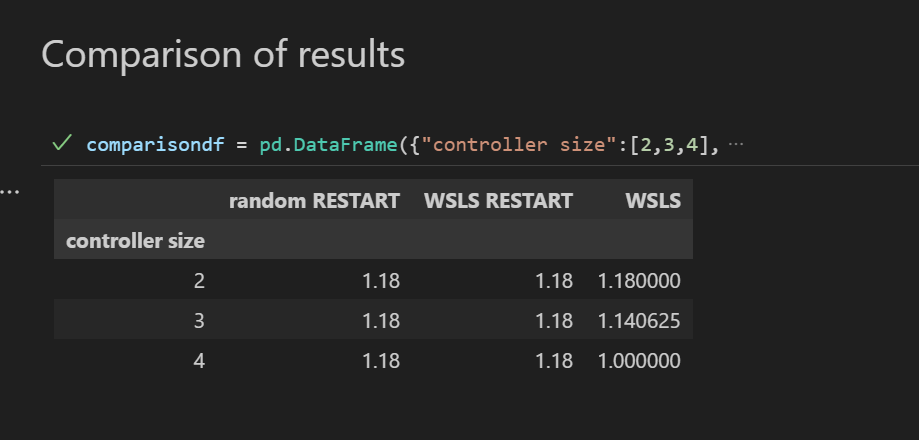

Bayesian POMDP value

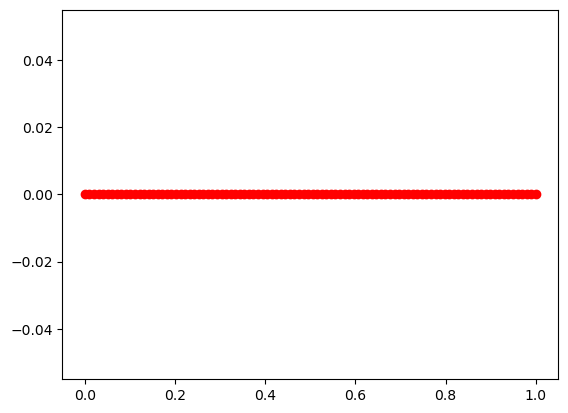

In [10]:
# construct belief points on segment
def belief_points(num_points):
    # define segment
    segment = (0,1)
    # return list of belief points where first element if belief to be in the first state
    # and second element is belief to be in the second state
    return [(point, 1 - point) for point in list(np.linspace(segment[0],segment[1],num_points))]
b = belief_points(100)
# plot first element in points in b on segment
plt.plot([point[0] for point in b], [0 for point in b], 'ro')

In [11]:
# belief update function
def belief_update(belief_point, action, observation, state_transition_model, observation_model):
    # belief update formula
    new_belief_point = [0 for i in range(len(belief_point))]
    for sprime in range(len(belief_point)):
        # sum_s b(s) * P(s'|s,a) * O(o|s', a)
        numerator = sum(belief_point[state] *
                        observation_model[sprime, action, observation] *
                        state_transition_model[sprime, action, state] 
                        for state in range(len(belief_point)))
        # sum_s,s' b(s) * P(s'|s,a) * O(o|s', a)
        denominator = sum(belief_point[state] *
                        observation_model[sp, action, observation] *
                        state_transition_model[sp, action, state] 
                        for state,sp in product(range(len(belief_point)),range(len(belief_point)))
                        )
        if denominator != 0:
            new_belief_point[sprime] = numerator / denominator
    return tuple(new_belief_point)
# new_belief_point = belief_update(b[0], 1, 0, state_transition_model, observation_model)
# type(new_belief_point)

In [12]:
# closest belief function
def closest_belief(belief_point, belief_list):
    return min(belief_list, key = lambda x: sum((x[i] - belief_point[i])**2 for i in range(len(belief_point))))
# type(closest_belief((0.6,0.4),[(0,1),(1,0)]))

In [13]:
# value iteration algorithm
def value_iteration_bp(beliefpoints, tol, state_transition_model, observation_model, rewards, num_states, num_actions, num_observations, gamma):
    # initialize value function V(b) = 0 for each b
    valuefun = { bp: 0 for bp in beliefpoints}
    tempvaluefun = { bp: 0 for bp in beliefpoints}
    # best action
    bestaction = {bp: 0 for bp in beliefpoints}
    # delta which tells us to stop after exceeding tolerance
    # value iteration algo
    i = 0
    while True:
        delta = 0
        #print(i)
        for bp in beliefpoints:
            # bellman operator
            quality = [0 for i in range(num_actions)]
            for action in range(num_actions):
                # sum_s,s',y b(s) * P(s'| s, a) * f(y| s', a) * (r(s,a) + gamma * V(b'(.|a, y)))
                quality[action] = sum(
                bp[state]* 
                observation_model[stateprime, action, obs]* 
                state_transition_model[stateprime, action, state]*
                (rewards[state,action]+
                gamma *
                valuefun[closest_belief(
                belief_update(bp, action, obs, state_transition_model, observation_model),
                beliefpoints
                )]
                ) 
                for state, stateprime, obs in 
                product(range(num_states), range(num_states), range(num_observations)))
            # take max over actions and update V'
            tempvaluefun[bp] = max(quality)
            # update best action
            bestaction[bp] = quality.index(max(quality))
            # update delta = max(delta, |V(b) - V'(b)|)
            delta = max(delta, abs(tempvaluefun[bp] - valuefun[bp]))
        # update value function V <- V'
        valuefun = tempvaluefun.copy()
        # print(delta)
        if delta <= tol:
            break
        i += 1
    return valuefun, bestaction

In [14]:
v,ba = value_iteration_bp(b,10**-10, 
                        state_transition_model, observation_model, reward_model, 
                        num_states, num_actions, num_observations, 
                        gamma)

In [15]:
# # plot value function V(b)
# plt.plot([bp[0] for bp in b], [v[bp] for bp in b], label = "V(b)")
# # plot belief points with best action = 0
# plt.plot(
#     [point[0] for point in b if ba[point] == 0],
#     [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {0}")
# # plot belief points with best action = 1
# plt.plot(
#     [point[0] for point in b if ba[point] == 1],
#     [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {1}")
# # legend
# plt.legend(loc = "upper right")

In [36]:
# compare with FSC QCLP
number_instances = 1
controller_size_list = [2, 3, 4]
# dictionary containing for each FSC size the objective function
valuefsc = {fsc_size: [] for fsc_size in controller_size_list}
# choosing a random sample of belief points for less optimization calls
sample_size = 10
sample_b = random.sample(b, k = sample_size)
sample_b.sort(key= lambda x: x[0])
for fsc_size in controller_size_list:
    for bp in sample_b:
        # b0 distribution over states according to belief point
        bdist = np.array(bp)
        # run QCLP optimization
        sol = opt_instances(controller_size_list,
                            number_instances,num_states, num_actions, num_observations, 
                            bdist, gamma, 
                            state_transition_model, reward_model, observation_model, 
                            obj = obj)
        # add max objective funciton under this belief point 
        valuefsc[fsc_size].append(sol[fsc_size]["max obj"])

model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.6.1 \x3a Requested accuracy could not be
      achieved.; 199 iterations, objective 1.2891414141414144; Nonlin
      evals\x3a constrs = 79, Jac = 78.
model.name="unknown";
    - termination condition: optimal
    - message from solver: SNOPT 7.6.1 \x3a Requested accuracy could not be
      achieved.; 221 iterations, objective 1.2949494949497682; Nonlin
      evals\x3a constrs = 29217, Jac = 29216.


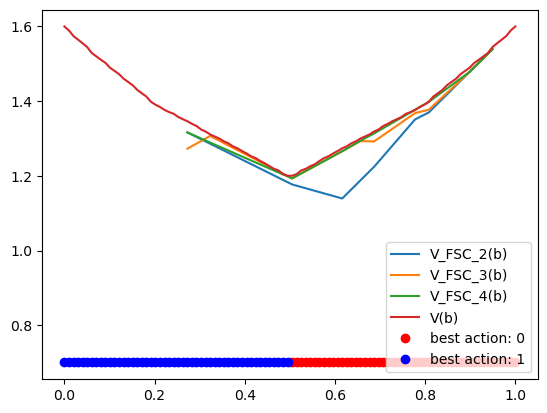

In [43]:
# plot objective function for each size
for fsc_size in controller_size_list:
    plt.plot([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {0}")

# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {1}")

# legend
plt.legend(loc = "lower right")

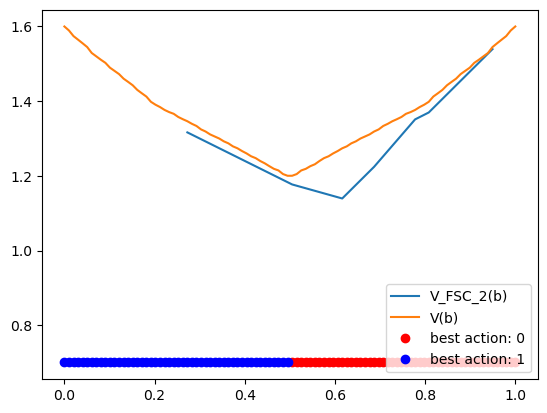

In [40]:
fsc_size = 2
plt.plot([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {0}")

# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {1}")

# legend
plt.legend(loc = "lower right")

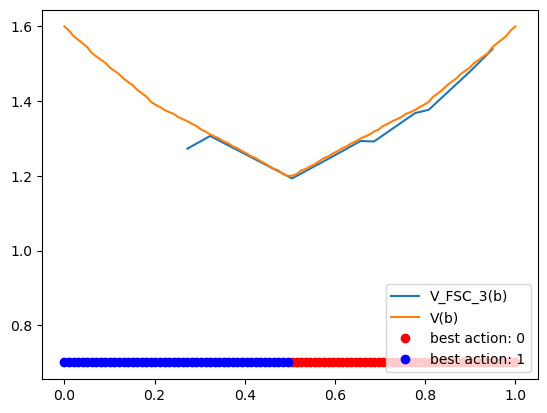

In [41]:
fsc_size = 3
plt.plot([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {0}")

# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {1}")

# legend
plt.legend(loc = "lower right")

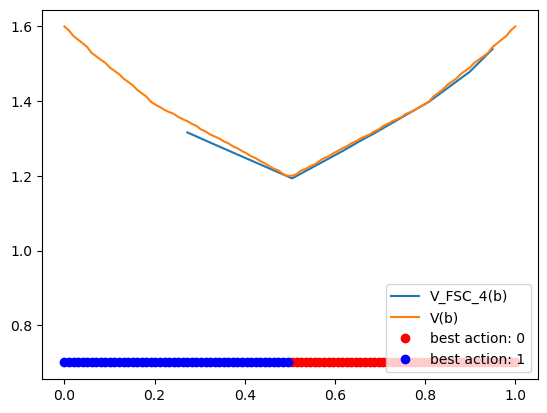

In [42]:
fsc_size = 4
plt.plot([bp[0] for bp in sample_b], valuefsc[fsc_size] , label = f"V_FSC_{fsc_size}(b)")

# # plot value function V(b)
plt.plot([bp[0] for bp in b], [v[bp] for bp in b], label = "V(b)")

# plot belief points with best action = 0
plt.plot(
    [point[0] for point in b if ba[point] == 0],
    [min(v.values()) - 0.5 for point in b if ba[point] == 0], 'ro', label = f"best action: {0}")

# plot belief points with best action = 1
plt.plot(
    [point[0] for point in b if ba[point] == 1],
    [min(v.values()) - 0.5 for point in b if ba[point] == 1], 'bo', label = f"best action: {1}")

# legend
plt.legend(loc = "lower right")